<img src="logo.png" alt="alt text" width="300" height="75">

<br>

<em>Copyright by Fairbanks Capital, LLC</em>

# Machine Learning in Higher Ed

#### *Binary Classification Using Logistic Regression*

**Author:** Cole Fairbanks

**GitHub Repo:** https://github.com/colefairbanks/trees-clientchurn/tree/main

#### Table of Content

1. Project Summary
2. Data Source & Libraries
3. Feature Engineering
4. Descriptive Statistics
5. Train, Test, Split
6. Helper Functions
7. Decision Tree, Random Forest, AdaBoost, XGBoost Models
8. Model Optimization
9. A Few Notes on Deployment
10. Business Value-Add & Real World Implications

#### Project Summary

This client churn project consists of a binary classification model that predicts which bank customers are likely to exit.  Knowing it is generally more expensive to acquire a new customer than retain an existing one, the ultimate goal is to prevent churn by providing the bank with a list of at-risk customers. The model itself showcases tree-based methods like decision trees, random forests, and includes boosting methods such as AdaBoost and XGBoost. Additionally, there is a Deployment section that dicusses a few practicle MLOps ideas.  Finally, there is Business Value-Add section that covers cost savings and real world implications.

#### Data Source

The following enrollment dataset contains 36 feature columns and 1 target column, "target."  It can be found at:

https://doi.org/10.24432/C5MC89


* enrollment.csv: higher ed enrollment data from Portugal between 2008 - 2019. Contains variables:

   * **marital_status:** 1 – single 2 – married 3 – widower 4 – divorced 5 – facto union 6 – legally separated
   * application_mode
   * application_order
   * **course:** academic class.  33 - Biofuel Production Technologies 171 - Animation and Multimedia Design 8014 - Social Service (evening attendance) 9003 - Agronomy 9070 - Communication Design 9085 - Veterinary Nursing 9119 - Informatics Engineering 9130 - Equinculture 9147 - Management 9238 - Social Service 9254 - Tourism 9500 - Nursing 9556 - Oral Hygiene 9670 - Advertising and Marketing Management 9773 - Journalism and Communication 9853 - Basic Education 9991 - Management (evening attendance)
   * **daytime_attendance:** 1 – daytime 0 - evening
   * **level_of_education:** amount of formal schooling.  1 - Secondary education 2 - Higher education - bachelor's degree 3 - Higher education - degree 4 - Higher education - master's 5 - Higher education - doctorate 6 - Frequency of higher education 9 - 12th year of schooling - not completed 10 - 11th year of schooling - not completed 12 - Other - 11th year of schooling 14 - 10th year of schooling 15 - 10th year of schooling - not completed 19 - Basic education 3rd cycle (9th/10th/11th year) or equiv. 38 - Basic education 2nd cycle (6th/7th/8th year) or equiv. 39 - Technological specialization course 40 - Higher education - degree (1st cycle) 42 - Professional higher technical course 43 - Higher education - master (2nd cycle)
   * **previous_admission_exam_grade:**  Upon completion of upper secondary school, students in Portugal are required to pass a national examination in order for them to be able to apply for higher education studies. This exam is graded according to an assessment scale that ranges from a minimum passing grade of 95 points to a maximum of 200 points.  This is the first exam attempt.
   * **nationality:** country of origin.  1 - Portuguese; 2 - German; 6 - Spanish; 11 - Italian; 13 - Dutch; 14 - English; 17 - Lithuanian; 21 - Angolan; 22 - Cape Verdean; 24 - Guinean; 25 - Mozambican; 26 - Santomean; 32 - Turkish; 41 - Brazilian; 62 - Romanian; 100 - Moldova (Republic of); 101 - Mexican; 103 - Ukrainian; 105 - Russian; 108 - Cuban; 109 - Colombian
   * **mother_qualification:**  1 - Secondary Education - 12th Year of Schooling or Eq. 2 - Higher Education - Bachelor's Degree 3 - Higher Education - Degree 4 - Higher Education - Master's 5 - Higher Education - Doctorate 6 - Frequency of Higher Education 9 - 12th Year of Schooling - Not Completed 10 - 11th Year of Schooling - Not Completed 11 - 7th Year (Old) 12 - Other - 11th Year of Schooling 14 - 10th Year of Schooling 18 - General commerce course 19 - Basic Education 3rd Cycle (9th/10th/11th Year) or Equiv. 22 - Technical-professional course 26 - 7th year of schooling 27 - 2nd cycle of the general high school course 29 - 9th Year of Schooling - Not Completed 30 - 8th year of schooling 34 - Unknown 35 - Can't read or write 36 - Can read without having a 4th year of schooling 37 - Basic education 1st cycle (4th/5th year) or equiv. 38 - Basic Education 2nd Cycle (6th/7th/8th Year) or Equiv. 39 - Technological specialization course 40 - Higher education - degree (1st cycle) 41 - Specialized higher studies course 42 - Professional higher technical course 43 - Higher Education - Master (2nd cycle) 44 - Higher Education - Doctorate (3rd cycle)
   * **father_qualification:** same fields as mother_qualifications.
   * **mother_occupation:** 0 - Student 1 - Representatives of the Legislative Power and Executive Bodies, Directors, Directors and Executive Managers 2 - Specialists in Intellectual and Scientific Activities 3 - Intermediate Level Technicians and Professions 4 - Administrative staff 5 - Personal Services, Security and Safety Workers and Sellers 6 - Farmers and Skilled Workers in Agriculture, Fisheries and Forestry 7 - Skilled Workers in Industry, Construction and Craftsmen 8 - Installation and Machine Operators and Assembly Workers 9 - Unskilled Workers 10 - Armed Forces Professions 90 - Other Situation 99 - (blank) 122 - Health professionals 123 - teachers 125 - Specialists in information and communication technologies (ICT) 131 - Intermediate level science and engineering technicians and professions 132 - Technicians and professionals, of intermediate level of health 134 - Intermediate level technicians from legal, social, sports, cultural and similar services 141 - Office workers, secretaries in general and data processing operators 143 - Data, accounting, statistical, financial services and registry-related operators 144 - Other administrative support staff 151 - personal service workers 152 - sellers 153 - Personal care workers and the like 171 - Skilled construction workers and the like, except electricians 173 - Skilled workers in printing, precision instrument manufacturing, jewelers, artisans and the like 175 - Workers in food processing, woodworking, clothing and other industries and crafts 191 - cleaning workers 192 - Unskilled workers in agriculture, animal production, fisheries and forestry 193 - Unskilled workers in extractive industry, construction, manufacturing and transport 194 - Meal preparation assistants
   * **father_occupation:** same fields as mother_occupation.
   * **admission_exam_grade:** Upon completion of upper secondary school, students in Portugal are required to pass a national examination in order for them to be able to apply for higher education studies. This exam is graded according to an assessment scale that ranges from a minimum passing grade of 95 points to a maximum of 200 points.  This is the second exam attempt.
   * **displaced:** 1 – yes 0 – no
   * **special_needs:** 1 – yes 0 – no
   * **debtor:** 1 – yes 0 – no
   * **tuition_fees_up_to_date:** 1 – yes 0 – no
   * **gender:** 1 – male 0 – female
   * **scholarship_holder:** 1 – yes 0 – no
   * **age_of_enrollment:** Age of studend at enrollment
   * **international:** 1 – yes 0 – no
   * **first_semester_classes_credited:** Number of classes credited in the 1st semester
   * **first_semester_classes_enrolled:** Number of classes enrolled in during the 1st semester
   * **first_semester_class_evaluations:** Number of class evaluations completed during 1st semester
   * **first_semester_classes_approved:** Number of classes approved during 1st semester
   * **first_semester_grade:** Grade point average in the 1st semester (between 0 and 20)
   * **first_semester_withoutevaluations:** Number of classes with no evaluations during 1st semester
   * **second_semester_credited:** Number of classes credited in the 2nd semester
   * **second_semester_enrolled:** Number of classes enrolled in during the 2nd semester
   * **second_semester_evaluations:** Number of class evaluations completed during 2nd semester
   * **second_semester_approved:** Number of classes approved during 2nd semester
   * **second_semester_grade:** Grade point average in the 2nd semester (between 0 and 20)
   * **second_semester_withoutevaluations:** Number of classes with no evaluations during 2nd semester
   * **unemployment_rate:** Unemployment rate (%)
   * **inflation_rate:** Inflation rate (%)
   * **gdp:** National Gross Deomestic Product (GDP)
   * **target:** Target. The problem is formulated as a three category classification task (dropout, enrolled, and graduate) at the end of the normal duration of the course

    **Citation:** Realinho,Valentim, Vieira Martins,Mónica, Machado,Jorge, and Baptista,Luís. (2021). Predict students' dropout and academic success. UCI Machine Learning Repository. https://doi.org/10.24432/C5MC89.

#### Load Libraries & Data

In [116]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
from faker import Faker
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import scikitplot as skplt
from sklearn import metrics

After importing the required libraries, the churn.csv file is read into a pandas dataframe with the first 5 rows displayed.

In [117]:
df = pd.read_csv('/Users/colefairbanks/GitHub/logistic-enrollment/enrollment.csv')
df.head()

,marital_status,application_mode,application_order,course,daytime_attendance,level_of_education,previous_qualification_grade,nationality,mother_qualification,father_qualification,...,second_semester_credited,second_semester_enrolled,second_semester_evaluations,second_semester_approved,second_semester_grade,second_semester_withoutevaluations,unemployment_rate,inflation_rate,gdp,target
0,1,7,1,9556,1,4,190.0,1,5,5,...,1,1,1,1,12.500000,0,11.1,0.6,2.02,Dropout
1,1,15,1,9500,1,1,190.0,108,3,2,...,0,7,10,5,12.420000,0,12.4,0.5,1.79,Enrolled
2,1,39,1,9500,1,40,130.0,1,1,1,...,1,8,9,8,14.077778,0,16.2,0.3,-0.92,Graduate
3,1,10,1,9085,1,1,184.4,22,2,19,...,0,6,10,5,14.333333,0,11.1,0.6,2.02,Graduate
4,1,39,1,9500,1,3,133.8,1,3,37,...,1,8,9,8,16.582222,0,15.5,2.8,-4.06,Graduate


#### Feature Engineering

The importance of feature engineering cannot be underscored enough when building machine learning dt_models.  The old mantra, "garbage-in garbage-out," can many times be remedied by handling missing data, non-linearity, complex dimensionality, etc. during the feature engineering process.  By scrubbing clean the data flowing into your dt_model, you can expect vastly improved performance.

That said, it is always a good idea to use the .info() function to get a feel for dataset quality.

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   marital_status                      4424 non-null   int64  
 1   application_mode                    4424 non-null   int64  
 2   application_order                   4424 non-null   int64  
 3   course                              4424 non-null   int64  
 4   daytime_attendance                  4424 non-null   int64  
 5   level_of_education                  4424 non-null   int64  
 6   previous_qualification_grade        4424 non-null   float64
 7   nationality                         4424 non-null   int64  
 8   mother_qualification                4424 non-null   int64  
 9   father_qualification                4424 non-null   int64  
 10  mother_occupation                   4424 non-null   int64  
 11  father_occupation                   4424 no

In [119]:
id_list = []

def generate_student_id(index):
    if 0 <= index <= len(df):
        unique_id = f'930{index:04d}'
        return unique_id
    else:
        return "Invalid Index"

# Generate unique student IDs
for index in range(0, len(df)):
    student_id = generate_student_id(index)
    id_list.append(student_id)

df['student_id'] = id_list


In [120]:
# Create an instance of the Faker class
fake = Faker()

#
names_list = []

#
for _ in range(len(df)):
    first_name = fake.first_name()
    last_name = fake.last_name()
    names_list.append(first_name + ' ' + last_name)

#
df['student_name'] = names_list

As you can see, this dataset practically came gift-wrapped - no null values, correct data types, and a nice 10,000 row sample.  However, there is missing information that was probably removed on-purpose for privacy reasons that we can recreate for real-world application; namely, email address and phone number.

* Email addresses are created based on "Surname" and simply adding "@gmail.com."
* Phone numbers are random, unique 9-digit numbers.

In [121]:
df['email'] = df['student_name'].str.split(' ').str[0].str.lower() + '.' + df['student_name'].str.split(' ').str[1].str.lower() + '@gmail.com'

In [122]:
df['phone'] = [random.randint(1000000000, 9999999999) for i in range(len(df))]
df['phone'] = df['phone'].astype(str)
df['phone'] = df['phone'].str[:3] + '-' + df['phone'].str[3:6] + '-' + df['phone'].str[6:]

Data Scientists who work with classification dt_models and customer data tend to pay attention to whether each column contains numeric or string values in addition to how they are grouped.  CustomerId, Surname, Email, and Phone, while typical fields, present a problem - they are unique and likely irrelevant.  Therefore, we should remove these columns; however, before doing so, we need a way to add back this information later, as our ultimate goal is to target these customers to prevent them from churning.  And so, we will create mapping dictionaries that are tied to unique customer IDs.

In [123]:
email_dict = df[['student_id', 'email']].set_index('student_id')['email'].to_dict()
phone_dict = df[['student_id', 'phone']].set_index('student_id')['phone'].to_dict()
surname_dict = df[['student_id', 'student_name']].set_index('student_id')['student_name'].to_dict()

With the information saved, we can now drop the irrelevant columns.

In [124]:
df.drop(['student_name', 'email', 'phone'], axis=1, inplace=True)

However, we are not going to drop "CustomerId", as this what our dictionaries eventually will map to.  Instead, we are going to set the index to this field instead of using standard row numbers.  Doing so ensures we can retain this information throughout the dt_model without adding additional noise.

In [125]:
df = df.set_index('student_id')

Another problem we face as of July 12, 2023 is sklearn's inability to interpret non-numerical text as categorical.  This affects "Gender" and "Geography" within our current dataframe, which contain: Female, Male, France, Germany, and Spain.

In [126]:
#df.groupby(['Gender'], as_index=False).count()[['Gender']]

In [127]:
#df.groupby(['Geography'], as_index=False).count()[['Geography']]

Our first instinct might be to assign a value like 0 to Female and 1 to Male - or 0 to France, 1 to Germany, and 2 to Spain.  However, this is risky, because sklearn might interpret these as ordinal values, which inserts bias via an unintentionally ranking.

Instead, we can implement a technique called "one-hot encoding" using the .get_dummies() pandas function.  This involves automatically creating new columns with binary classifications of True and False.  You will notice astype(int) is added - this converts True and False to integers 0 and 1.

* Bonus: drop_first=True is included to eliminate "Geography_France."  Why? To prevent multicollinearity - correlations between features.  Having drop_first is good statistical hygiene in my opinion, especially if dt_models like these are designed to be scaled eventually.

In [128]:
df.loc[df['target'] == 'Graduate', 'target'] = 0
df.loc[df['target'] == 'Dropout', 'target'] = 1
df.loc[df['target'] == 'Enrolled', 'target'] = 2

In [129]:
df['target'] = df['target'].astype(int)

In [130]:
current_student_df = df.loc[df['target'] == 2]
df = df.loc[df['target'] != 2]

Let's order our columns and take a look at our cleaned, numeric dataframe.

In [131]:
#df = df[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'
        # , 'Geography_Germany', 'Geography_Spain', 'Gender_Male', 'Exited']]
df.head()

,marital_status,application_mode,application_order,course,daytime_attendance,level_of_education,previous_qualification_grade,nationality,mother_qualification,father_qualification,...,second_semester_credited,second_semester_enrolled,second_semester_evaluations,second_semester_approved,second_semester_grade,second_semester_withoutevaluations,unemployment_rate,inflation_rate,gdp,target
student_id,,,,,,,,,,,,,,,,,,,,,
9300000,1,7,1,9556,1,4,190.0,1,5,5,...,1,1,1,1,12.500000,0,11.1,0.6,2.02,1
9300002,1,39,1,9500,1,40,130.0,1,1,1,...,1,8,9,8,14.077778,0,16.2,0.3,-0.92,0
9300003,1,10,1,9085,1,1,184.4,22,2,19,...,0,6,10,5,14.333333,0,11.1,0.6,2.02,0
9300004,1,39,1,9500,1,3,133.8,1,3,37,...,1,8,9,8,16.582222,0,15.5,2.8,-4.06,0
9300005,1,1,1,9556,1,1,180.0,103,5,3,...,0,8,8,0,0.000000,0,16.2,0.3,-0.92,1


Looks good.  Next, descriptive statistics.

#### Descriptive Statistics

Descriptive statistics summarize and describe the main features of datasets and help data science professionals gain a quick understanding of their properties, which can guide further analyses and decision-making processes.

For classification models, class imbalance is always front-and-center when examining datasets for the first time.  Having imbalanced data refers to a situation where the distribution of classes in a dataset is highly skewed, meaning that one class significantly outnumbers the others. This imbalance can lead to signficiant bias toward the majority class, resulting in poor predictive performance of the minority class.  

Using a seaborn count plot is a quick an easy way to determine whether a class imbalanced is present.  In the visualization below, we can see that out of 10,000 clients, 2,000 or 20% will churn.  Given this is not closer to a 50-50 split, we are working with a class imbalance and need to act accordingly.

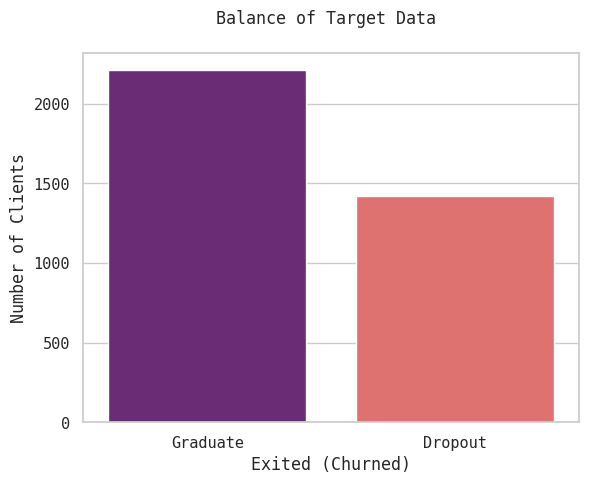

In [132]:
sns.countplot(data=df, x='target', palette='magma')
plt.title('Balance of Target Data \n')
plt.xlabel('Exited (Churned)')
plt.ylabel('Number of Clients')
plt.xticks([0, 1], ['Graduate', 'Dropout']);

In addition to class imbalance, another useful insight is a correlation heatmap that establishes the strength of relationships between features.  In the heatmap below, we are focused on which features impact "Exited," our target variable, the most.  In this case, it is "Age" and "IsActiveMember," which may be worth exploring more.

In [133]:
correlation_matrix = df.corr()

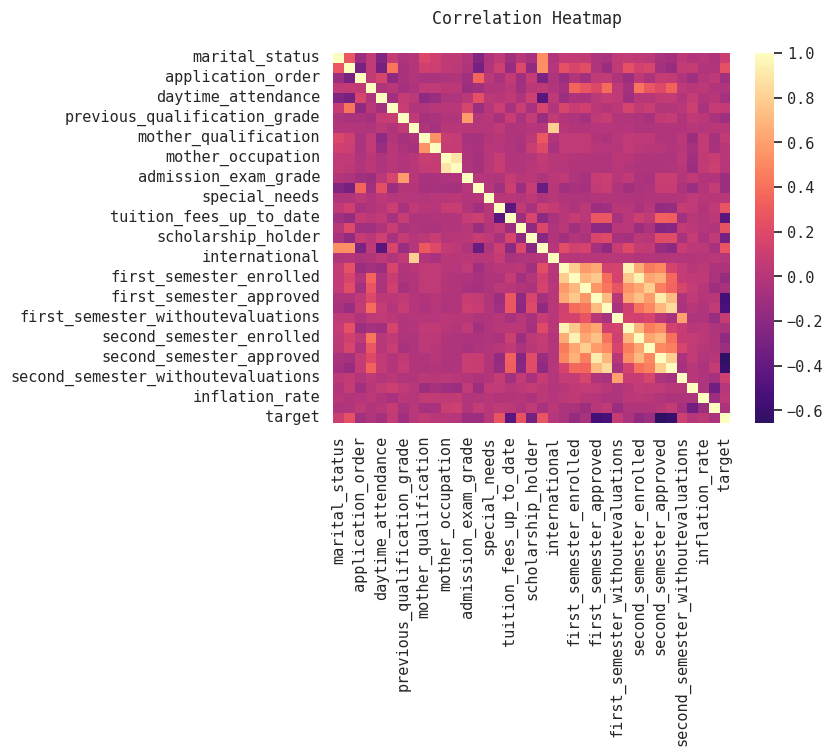

In [134]:
sns.heatmap(correlation_matrix, annot=False, cmap="magma", center=0)
plt.title("Correlation Heatmap \n ")
plt.show()

Digging deeper - "Age" seems to have the strongest relationship with client churn.  Since age is numerical and ranges from clients in their 20s to 90s, a box plot would be great for visually evaluating median ages and the average spread for clients who stayed and churned.  One immediate insight from the box plot below is that clients who are older tend to churn more than younger clients.  A question for later might be, why?

#### Adressing Multicollinearity

Multicollinearity refers to a situation in which two or more explanatory variables in a multiple regression model are highly linearly related. [This was directly from Wikipedia]. Multicollinearity occurs when your model includes multiple factors that are correlated not just to your target variable, but also to each other.

One of the assumptions of linear and logistic regression is that the feature columns are independent of each other. Therefore, Multicollinearity is obviously violating the assumption of linear and logistic regression because it shows that the independent feature i.e the feature columns are dependent on each other.
Also though your model will be giving a high accuracy without eliminating multicollinearity at times, but it can’t be relied on for real-world data. Also, the coefficients become very sensitive to small changes in the model. In simple terms, the model will not be able to generalize, which can cause tremendous failure if your model is in the production environment. Another important reason for removing multicollinearity from your dataset is to reduce the development and computational cost of your model, which leads you to a step closer to the ‘perfect’ model. So be cautious and don’t skip this step!!

In [135]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [136]:
#Method 2 to Detect MultiCollinearity

def get_VIF(df, target):
    X = add_constant(df.loc[:, df.columns != target])
    seriesObject = pd.Series([variance_inflation_factor(X.values,i) for i in range(X.shape[1])] , index=X.columns,)
    return seriesObject

In [137]:
target = 'target'
get_VIF(df,target).sort_values(ascending=False)

const                                 242.533104
first_semester_enrolled                25.330958
second_semester_enrolled               17.393323
first_semester_credited                17.236526
first_semester_approved                16.248727
second_semester_credited               13.335574
second_semester_approved               13.136995
second_semester_grade                   6.595458
first_semester_grade                    5.718419
father_occupation                       4.766658
mother_occupation                       4.753764
first_semester_evaluations              4.278754
second_semester_evaluations             3.588236
international                           2.789083
nationality                             2.774103
age_of_enrollment                       2.351926
course                                  2.316232
application_mode                        1.838529
first_semester_withoutevaluations       1.773721
second_semester_withoutevaluations      1.649426
admission_exam_grade

In [138]:
df = df.loc[:,~df.columns.str.contains('first_semester')]

current_student_df = current_student_df.loc[:,~current_student_df.columns.str.contains('first_semester')]

In [139]:

df = df.loc[:,~df.columns.str.contains('international')]
df = df.loc[:,~df.columns.str.contains('father_qualification')]

current_student_df = current_student_df.loc[:,~current_student_df.columns.str.contains('international')]
current_student_df = current_student_df.loc[:,~current_student_df.columns.str.contains('father_qualification')]

Could have eliminated other second semester factors but thought grades and enrollment were important data to keep.

#### Train, Test | Split

As a first step, the feature columns need to be separated from the target, "Exited."

In [140]:
X = df.iloc[:, :-1]
y = df['target']

Once seperated, we can implement sklearn's classic train_test_split() function.  A standard test size of 0.20 is used with a random state for replication.

1. **Important Note:** "stratify=y" is an important hyperparameter for our train test split.  It ensures that both the training and test sets have a representative distribution of classes, which addresses much of the class imbalance issue.

In [141]:
enrolled_percentage = len(current_student_df)/len(df)

In [142]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=enrolled_percentage, stratify=y, random_state=101)

In [143]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

#### Helper Functions

So, there are 2 helper functions that were created to minimize code duplication.

1. **Model Metrics:**  the first function expands on sklearn's built-in classification and confusion matrix. It does this by creating a 1-row dataframe containing our custom accuracy metrics (more on that in the section below), which lays out visually the cost of doing nothing versus implementing the predictive model.

2. **Metrics Plots:** the second function creates a compact, side-by-side visualization that highlights the confusion matrix and feature importance with the same color palette and font.

3. **Hyperparameter Plots:** the third function displays the grid search results of the best performing model visually so that a Data Scientist could determine which hyperparameters would be optimal.

In [144]:
def metrics_plots(cm, y_test, model_predictions):
    
    #creates subplot that enables two visualizations in the same cell
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    #sets color palette for heatmap, ROC, and makes font consistent with Jupyter font
    color_palette = sns.color_palette('magma', as_cmap=True)
    magma4_color = sns.color_palette("magma")[4]
    sns.set(style='whitegrid', font='monospace')

    #plots confusion matrix and changes titles and labels
    plot1 = sns.heatmap(log_cm, cmap=color_palette, annot=True, fmt='g', vmax=400, ax=axes[0])
    axes[0].set_title('Logistic Model' + ': Confusion Matrix \n')
    axes[0].set_xlabel('\n Predictions')
    axes[0].set_ylabel('True Values \n')
    axes[0].xaxis.set_ticklabels(['Graduate', 'Dropout'])
    axes[0].yaxis.set_ticklabels(['Graduate', 'Dropout']);

    #calculates the false positive rate (fpr) and true positive rate (tpr) as well as the ROC and AUC metrics
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model_predictions)
    roc_auc = metrics.auc(fpr, tpr)

    #plots ROC curve, fillign space below curve with magma4 color, adjusts x and y ticks and limits, and removes grid lines
    plot2 = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot(ax=axes[1], color=magma4_color)
    plt.fill_between(fpr, tpr, color=magma4_color, alpha=0.3)
    plt.legend(['AUC = %0.2f' % roc_auc], loc='center')
    plt.title('Logistic Model: ROC Curve \n')
    plt.xticks([0, 1])
    plt.yticks([0, 1])

    plt.grid(False);

In [145]:
def feature_plots(df, coefs):

    #fits a logistic regression model that only takes second_semester_approved into account
    X = df['second_semester_approved']
    y = df['target']
    enrolled_percentage = len(current_student_df)/len(df)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=enrolled_percentage, stratify=y, random_state=101)
    X_train = np.reshape(X_train, (-1, 1))
    X_test = np.reshape(X_test, (-1, 1))
    scaler = StandardScaler()
    scaled_X_train = scaler.fit_transform(X_train)
    scaled_X_test = scaler.transform(X_test)
    log_model.fit(scaled_X_train,y_train);
    log_probabilities = log_model.predict_proba(scaled_X_test)
    y_test = y_test.replace(0, 'Actual Graduates')
    y_test = y_test.replace(1, 'Actual Dropouts')

    #creates subplot that enables two visualizations in the same cell
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    #sets color palette for plots, along with style and font
    color_palette = sns.color_palette('magma', as_cmap=True)
    magma4_color = sns.color_palette("magma")[4]
    sns.set(style='whitegrid', font='monospace')

    #plots scatterplot that contains dropout probabilities based on approved credit hours, the most relevant feature
    plot1 = sns.scatterplot(x = X_test.squeeze(), y = log_probabilities[:,1], hue = y_test, palette='magma', ax=axes[0])
    sns.despine(top=True, right=True, left=True, bottom=True)
    axes[0].set_title('Logistic Curve: Approved Credit Hours \n')
    axes[0].set_xticks([0, 5, 10, 15, 20])
    axes[0].set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
    axes[0].set_xlabel('\n Approved Credit Hours')
    axes[0].set_ylabel('Dropout Probability \n')
    axes[0].axhline(y=0.5, color='red', linestyle='--')
    axes[0].legend().set_title(None)
    axes[0].legend().get_frame().set_linewidth(0)
    axes[0].text(10, 0.52, 'Predicted Dropouts', horizontalalignment='center')
    axes[0].text(10, 0.45, 'Predicted Graduates', horizontalalignment='center')
    axes[0].grid(False)

    #plots bar graph that contains the coefficients of the most relevant features
    plot2 = sns.barplot(x=coefs.index, y=coefs.values, palette='magma', ax=axes[1])
    axes[1].set_title('Strength of Features \n')
    axes[1].set_ylabel('Coefficient \n')
    axes[1].set_yticks([-3, -2, -1, 0, 1])
    axes[1].tick_params(axis='x', rotation=90);

#### Performance Metrics & Evaluation

Let's talk about "accuracy" and what constitutes as the "best" model.  If this was a purely academic exercise, the classification report that includes precision, recall, f1, and accuracy would be enough for a decent grade.  However, the ultimate goal of one of these models deployed in the real world is to generate value in terms of dollars.  Therefore, we need custom metrics that reflect the highest amount of dollars saved or generated.  In the case of client churn, here is what the formula looks in simplest terms:


COST OF DOING NOTHING - COST OF IMPLEMENTING ML MODEL = COST SAVINGS

We know each time a client is lost, $100 is spent acquiring a new one and so, we know:

COST OF DOING NOTHING = NUMBER OF CHURNED CLIENTS * 100
COST OF DOING NOTHING = (FALSE NEGATIVES + TRUE POSITIVE) * ACQUISITION RATE

The cost of implementing the ML model is a bit more complex because if we do save a customer, it costs $50 in discounts and advertising.  However, our model will inevitably miss to > > detect some clients and therefore, our false negatives will still result in $100 loss:

COST OF IMPLEMENTING MODEL = (NUMBER OF CLIENTS WHO WE SAVED FROM CHURNING * 50) + (NUMBER OF CLIENTS WE THOUGHT WOULD CHURN WHO DIDN'T * 50) + (NUMBER OF CHURNED CLIENTS * 100)
COST OF IMPLEMENTING MODEL = (TRUE POSITIVES * 50) + (FALSE POSITIVES * 50) + (FALSE NEGATIVES * 100)

Now if you are asking, "Well, doesn't this assume there's a 100% capture rate?" or "What about the cost of compute?" then you are on the right track.  We will discuss some of those assumptions at the end of this notebook.  For simplicity's sake though, we will assume 100% capture, no computing costs, and no concessions for renewal aside from marketing.

#### Logistic Regression

Random Forests are an evolution of simple decision trees.  Using an ensemble approach, random forests combine multiple decision trees to create more robust, accurate models. They do this by implementing random sampling with replacement, known as "bootstrapping," as well as random feature selection.  Bootstrapping involves selecting multiple random samples with replacement, which means each subset may contain duplicate samples.  Random forests also consider a random subset of features rather than using all the features.  By introducing more randomness into the modeling process, the result is a versatile model that is extraordinarily hard to overfit.

In [146]:
log_model = LogisticRegressionCV()
log_model.fit(scaled_X_train,y_train);

In [147]:
log_predictions = log_model.predict(scaled_X_test)
log_probabilities = log_model.predict_proba(scaled_X_test)[:, 1]

In [148]:
coefs = pd.Series(index=X.columns,data=log_model.coef_[0])
coefs_df = pd.DataFrame(coefs, columns=['coefficients'])
coefs = coefs.loc[(coefs_df['coefficients'] > 0.5) | (coefs_df['coefficients'] < -0.5)]
coefs = coefs.sort_values()

In [149]:
log_cr = classification_report(y_test, log_predictions)
log_cm = confusion_matrix(y_test, log_predictions)

In [150]:
print(log_cr)

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       483
           1       0.91      0.86      0.89       311

    accuracy                           0.91       794
   macro avg       0.91      0.90      0.91       794
weighted avg       0.91      0.91      0.91       794



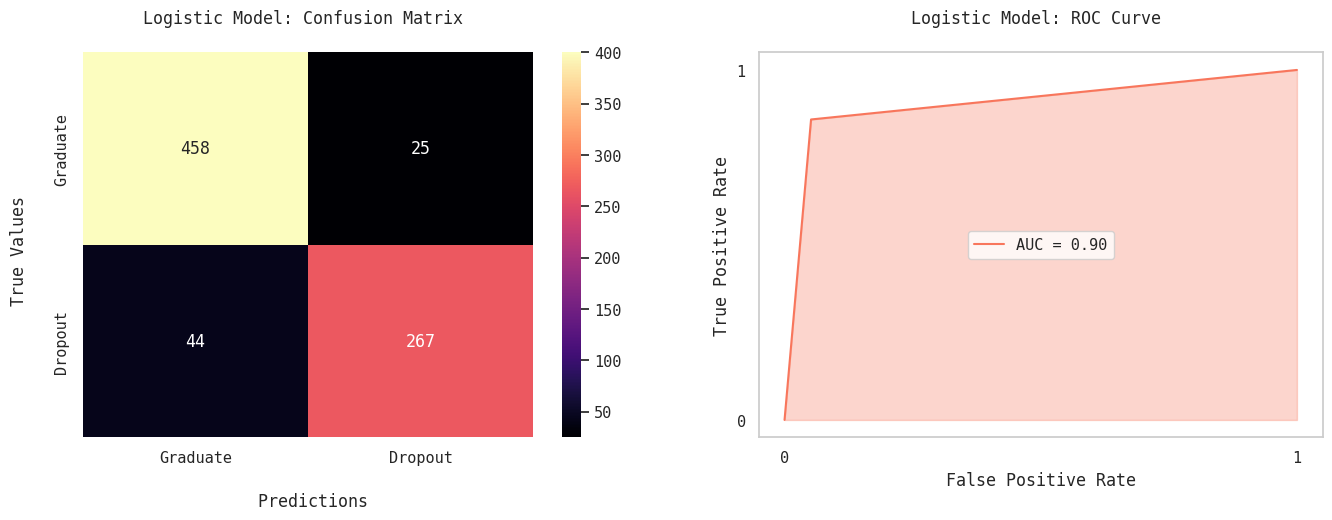

In [151]:
metrics_plots(log_cm, y_test, log_predictions)

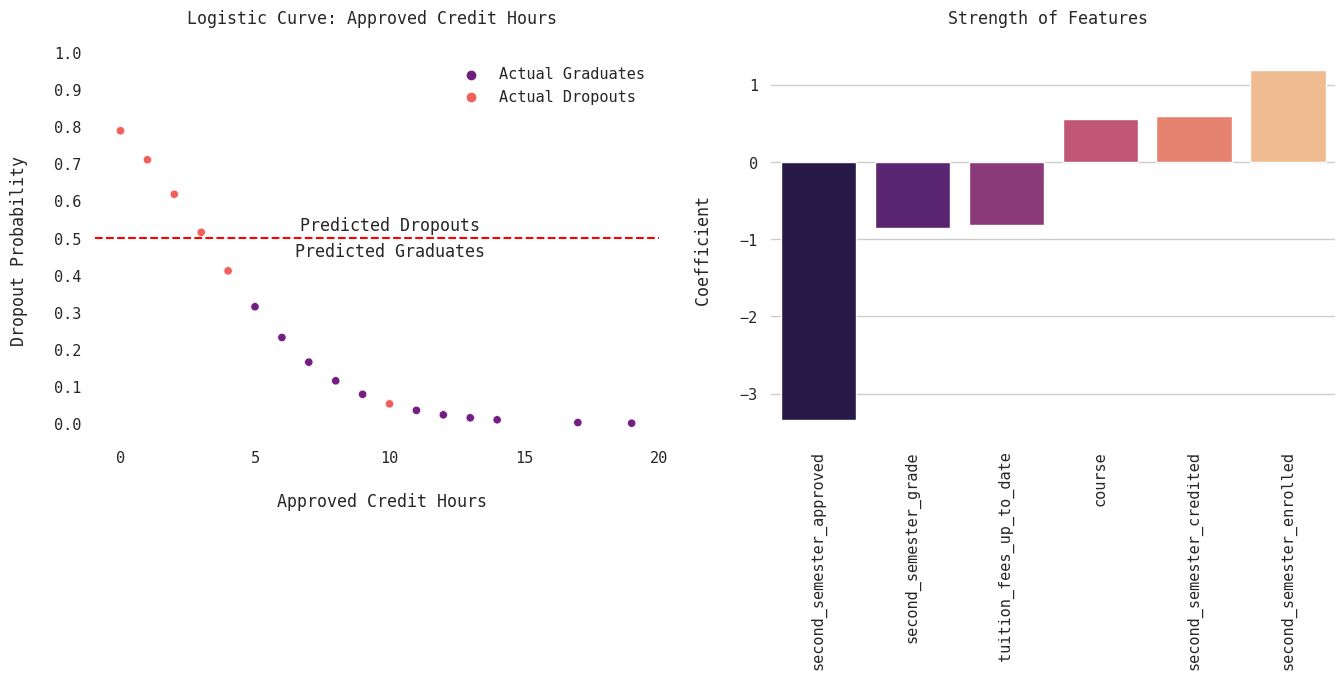

In [152]:
feature_plots(df, coefs)

In [153]:
X_current = current_student_df.iloc[:, :-1]
y_current = current_student_df['target']

In [154]:
scaled_X_final = scaler.fit_transform(X)
scaled_X_current = scaler.transform(X_current)

In [155]:
log_model_final = LogisticRegressionCV()
log_model_final.fit(scaled_X_final, y);

In [156]:
log_predictions_final = log_model_final.predict(scaled_X_current)
log_probabilities_final = log_model_final.predict_proba(scaled_X_current)[:, 1]

#### A Few Notes on Deployment

It's one thing to build a ML model, it's another to deploy it.  Beyond the academic exercise of train-test-split, I will elaborate on how to input optimized hyperparameters and actually produce a product that sellers and business leaders could use to generate value.

First, we create a new random forest model called "optimized_model" that contains the hyperparameters max_features and n_estimators.  We will set them equal to the best parameters generated from the prior section to generate "optimized_predictions."

Normally, we would be given a list of unseen customers that have not yet churned to make predictions; however, since we only have a historical sample of 10,000, let's pretend the test data is actually 2000 rows of customers that have not actually decided to leave the bank or not.  To do this, we create a new dataframe called "target_clients_df," recreate the "Exited" column, and set the values to '' (blank) for a visual.

In [164]:
current_student_df['target'] = log_predictions_final

In [175]:
(len(current_student_df.loc[current_student_df['target'] == 1]) - 70)/len(current_student_df.loc[current_student_df['target'] == 0])

0.49586776859504134

In [157]:
# target_clients_df = X_test
# target_clients_df['Exited'] = ''
# target_clients_df.head()

Next, we will fill the blanks in the Exited column with our optimized predictions and filter by 1, the class of client we believe will churn in the future.

In [158]:
# target_clients_df['Exited'] = optimized_predictions
# target_client_df = target_clients_df.loc[target_clients_df['Exited'] == 1]

Okay - we theoretically know which clients are likely to churn.  Now what?  Well, we need to produce a product that sellers and account managers can practically use to prevent customers from leaving.  In other words, we need a client list - one with phone numbers, emails, and names that sellers could use for contact purposes.  However, we removed that information to reduce noise...

Remember when we made dictionaries for surname, emails, and phone before dropping the columns?  This is why.  Because we set our index to CustomerId, we can:

1. reset the index without dropping it, bringing "CustomerId" back into the dataframe as a column
2. use the map() function to reestablish surname, email, and phone columns
3. create a compact list for sellers consisting of "CustomerId," "Surname," "Email," "Phone," and "Balance"


In [159]:
# #pulling CustomerId back out to dataframe by resettting index and setting drop to False
# target_clients_df = target_clients_df.reset_index(drop=False)

# #reestablishing surname, email, and phone columns using map()
# target_clients_df['Surname'] = target_clients_df['CustomerId'].map(surname_dict)
# target_clients_df['Email'] = target_clients_df['CustomerId'].map(email_dict)
# target_clients_df['Phone'] = target_clients_df['CustomerId'].map(phone_dict)

# #removes unwanted columns by specifying which ones to keep
# target_clients_df = target_clients_df[['CustomerId', 'Surname', 'Email', 'Phone', 'Balance']]

Did you notice we kept "Balance?"  Why?

Even though balance is not highly correlated with churn and therefore, not particularly useful to our model, balance is important to bankers for a 3 primary reasons:

1. **Liquidity**: Customer deposits provide banks with a stable source of funding. These deposits can be used to fund loans and other investments, which in turn generate income for the bank. Without customer balances, banks would have to rely more on expensive sources of funding, such as borrowing from other financial institutions.

2. **Interest Income**: Banks typically pay customers interest on their deposits, while also earning interest by lending out those funds to borrowers. The interest differential, known as the net interest margin, is a significant source of revenue for banks. Customers with balances contribute to this interest income.

3. **Regulatory Compliance**: Many banking regulations require banks to maintain a certain level of capital relative to their total deposits and liabilities. Customer balances contribute to the overall deposit base, which impacts a bank's regulatory compliance.



Therefore, if Sellers and Account Managers had to prioritize a list of customers to reach out to, it would likely be based on "Balance."  Customers who do not have a balance are generally considered low value customers.  Additionally, if those customers have already pulled out their funds, the liklihood of convincing them to stay is probably low.

That being said, we can sort the values by "Balance" in descending order and reset the index to "CustomerId" for a view of our final product.

In [160]:
# target_clients_df = target_clients_df.sort_values(by='Balance', ascending=False)
# target_clients_df = target_clients_df.set_index('CustomerId')
# target_clients_df

In a deployment environment, we would probably have a list of Sellers by territory that these at-risk clients would be sent to.  For the simplicity of this notebook though, we will export our final product as a CSV file.

In [161]:
# target_clients_df.to_csv('output_target_clients.csv')

#### Business Value & Real World Applications

**Why should companies implement client churn models like this?**

* It's a good question that great business leaders ask first.  The reason, of course - is tremendous value creation - both in terms of productivity as well as shareholder value.

**How does a ML model like this create value?**

* ML client churn models address the problem of scale.  While a few specialized full-time employees could certainly create a methodology to detect client churn, establish accuracy metrics, and reach out to clients as a prevention measure, it becomes more untenable as the sample size increases; not to mention more expensive.  Let's say it takes 2 full-time employees to track 10,000 clients - that's $200,000 in employee salary and benefits.  If the bank wants to scale up to 100,000 clients it faces paying 20 full-time workers $2,000,000 or perhaps more likely - paying 10 full-time workers that can't realistically take on the workload of 20 people and so, the quality of their client churn models suffer.

* With 3 Data Scientists and a ML model that does the mathematical heavy lifting, you can scale up to 1,000,000 clients, save big on fixed salary costs, and consistently reduce client churn without sacrificing model quality.

**What Real-World Costs & Considerations are Missing?**

* Cloud costs were the main component left out of this notebook for simplicity.  However, pricing for compute and storage is straightforward with providers like AWS, Azure, and GCP.  The overall cloud costs will depend on the data size; it's worth noting though - simple binary classification, in theory should not be compute-intensive, especially paired with a big data framework like apache spark.

* XGBoost tends to outperform simple random forests and so, I would be inclined to run more optimization tests with this model on large samples.  The reason I might choose a random forest over XGBoost though, like in this case, is because random forests are virtually impossible to overfit.  The same cannot be said for XGBoost.

* You wouldn't just use tree-based classification models to predict client churn.  Not only would you implement models like logistic regression, you would also run and optimize every major classification algorithm and automatically select a model with even more refined accuracy metrics.  Keep in mind though, while this may be optimal, it may not be as cost effective in the cloud as you think, given the heavy compute requirements.